In [15]:
# import necessary modules
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
import json
import numpy as np

#------------------------------------------
# Create a LinearSegmentedColormap object
cmap1=LinearSegmentedColormap.from_list("my_colormap", sns.color_palette("colorblind", n_colors=5))


sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("colorblind")

plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8
plt.rcParams["axes.titlepad"] = 20

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["axes.titlesize"] = 30
plt.rcParams['axes.labelsize'] = 23.5
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['text.usetex'] = False

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["savefig.dpi"]=300

In [2]:
input_genomes=snakemake.params.genome
input_sample=snakemake.params.sample
input_control=snakemake.params.control
input_workdir=snakemake.params.workdir
input_tombodir=snakemake.params.tombo_dir
input_threshold=snakemake.params.threshold_modfrac

output_modfrac_png=snakemake.output.modfrac_png
output_coverage_png=snakemake.output.coverage_png

output_dinucleotide_histogram_pdf=snakemake.output.dinucleotide
output_trinucleotide_histogram_pdf=snakemake.output.trinucleotide
output_tetranucleotide_histogram_pdf=snakemake.output.tetranucleotide
output_pentanucleotide_histogram_pdf=snakemake.output.pentanucleotide
output_hexanucleotide_histogram_pdf=snakemake.output.hexanucleotide


NameError: name 'snakemake' is not defined

In [16]:
threshold=input_threshold
genomes=[input_genomes]
sample=input_sample
control=input_control
workdir=input_workdir
tombo_dir=input_tombodir

%cd $workdir


/home/lmf/PETER/MODIFICATIONS_TOMBO/W09_2B


In [17]:
from statistics import mean 
from Bio import SeqIO
from itertools import repeat
import pandas as pd
import numpy as np
import os
        
def read_genome(fasta_file):
    fasta_sequences = SeqIO.parse(open(fasta_file),'fasta')
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)

    mono=[]
    di=[]
    tri=[]
    tetra=[]
    penta=[]
    hexa=[]
    hepta=[]
    octa=[]
    nona=[]
    deca=[]

    lines=sequence + "X"*9
    for i in range(len(lines)-9):
        mono.append(lines[i])
        di.append(lines[i]+ lines[i+1])
        tri.append(lines[i]+ lines[i+1] + lines[i+2])
        tetra.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3])
        penta.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4])
        hexa.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4] + lines[i+5])
        hepta.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4] + lines[i+5] + lines[i+6])
        octa.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4] + lines[i+5] + lines[i+6] + lines[i+7])
        nona.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4] + lines[i+5] + lines[i+6] + lines[i+7] + lines[i+8])
        deca.append(lines[i]+ lines[i+1] + lines[i+2] + lines[i+3] + lines[i+4] + lines[i+5] + lines[i+6] + lines[i+7] + lines[i+8] + lines[i+9])

    d = {'Mononucleotide':mono,'Dinucleotide':di,'Trinucleotide':tri,'Tetranucleotide':tetra,'Pentanucleotide':penta, "Hexanucleotide":hexa, "Heptanucleotide":hepta, "Octanucleotide":octa, "Nonanucleotide":nona, "Decanucleotide":deca}

    nucleotides_df = pd.DataFrame(d)
    nucleotides_df['Position']=list(range(0,len(lines)-9))

    return nucleotides_df

def read_modfrac(wig_file):
    greater_thans=[]
    sizes=[]
    means=[]
    position=0
    greater_than=0
    values=""

    n=0
    #WIG
    with open(wig_file) as fp:
        values=[]
        positions=[]
        greater_than=0
        for line in fp:
            n=n+1
            if n > 2:
                values.append(float(line.split()[1]))
                positions.append(float(line.split()[0]))
                if float(line.split()[1]) > threshold:
                    greater_than=greater_than+1
    modfrac_df=pd.DataFrame()
    modfrac_df["position"]=positions
    modfrac_df["Mod_fraction"]=values
    return modfrac_df


def read_valid_coverage(file_coverage):
    #Coverage
    coverage_value=[]
    coverage_position=[]

    #VALID COVERAGE
    with open(file_coverage) as fp:
        for line in fp:
            if not line.startswith("track") and not line.startswith("variable"):
                pos, cov=line.split()
                cov=int(cov)
                pos=int(pos)
                coverage_value.append(cov)
                coverage_position.append(pos)

    coverage_df=pd.DataFrame()
    coverage_df["position"]=coverage_position
    coverage_df["valid_coverage"]=coverage_value
    return coverage_df

def read_coverage_wig(wigfile):
    coverage=[1]
    mean_coverages_sample=[]
    genomes_cov_sample=[]
    values=""
    with open(wigfile) as fp:
        for line in fp:
            if (not line.startswith("track")) & (not line.startswith("variableStep")) :
                genome, low, high, cov=line.split("\t")
                if not genome in genomes_cov_sample:
                    genomes_cov_sample.append(genome)
                    mean_coverages_sample.append(mean((coverage)))
                    coverage=[]
                coverage.extend(repeat(int(cov), int(high)-int(low)))
    coverage_df=pd.DataFrame()
    coverage_df["coverage"]=coverage
    coverage_df["position"]=list(range(0,len(coverage)))

    return coverage_df

def read_modfrac_genome_denovo(genome,barcode, tombo_dir):
    print(genome, "denovo")
    fasta_file="GENOMES/" + genome + ".fasta"

      
    wig_file= tombo_dir +  genome + "_" + barcode +  ".tombo_denovo/"+ genome + "_" + barcode + "_denovo.dampened_fraction_modified_reads.plus.wig"
    file_valid_coverage= tombo_dir +  genome + "_" + barcode +  ".tombo_denovo/"+ genome + "_" + barcode + "_denovo.valid_coverage.plus.wig"
    file_coverage_sample= tombo_dir +  genome + "_" + barcode +  ".tombo_denovo/"+ genome + "_" + barcode + "_denovo.coverage.plus.bedgraph"
    
    
    nucleotides_df=read_genome(fasta_file)
    modfrac_df=read_modfrac(wig_file)
    valid_coverage_df=read_valid_coverage(file_valid_coverage)
    coverage_sample_df=read_coverage_wig(file_coverage_sample)
    coverage_sample_df = coverage_sample_df.rename(columns={'coverage': 'coverage_sample'})

    df=nucleotides_df.merge(modfrac_df, left_on="Position", right_on="position", how="left").merge(valid_coverage_df, left_on="Position", right_on="position", how="outer").merge(coverage_sample_df, left_on="Position", right_on="position", how="outer")
    return df

def read_modfrac_genome_sampleCompare(genome,sample,control,tombo_dir):
    print(genome, "sample compare")
    fasta_file="GENOMES/" + genome + ".fasta"
    wig_file= tombo_dir + genome + "_" + sample + "_" + control + ".tombo_sampleCompare/" + genome + "_" + sample + "_" + control +  ".dampened_fraction_modified_reads.plus.wig"
    file_valid_coverage= tombo_dir + genome + "_" + sample + "_" + control + ".tombo_sampleCompare/" + genome + "_" + sample + "_" + control +  ".valid_coverage.plus.wig"
    file_coverage_sample= tombo_dir + genome + "_" + sample + "_" + control + ".tombo_sampleCompare/" + genome + "_" + sample + "_" + control +  ".coverage.sample.plus.bedgraph"
    file_coverage_control= tombo_dir + genome + "_" + sample + "_" + control + ".tombo_sampleCompare/" + genome + "_" + sample + "_" + control +  ".coverage.control.plus.bedgraph"


    nucleotides_df=read_genome(fasta_file)
    modfrac_df=read_modfrac(wig_file)
    valid_coverage_df=read_valid_coverage(file_valid_coverage)
    coverage_sample_df=read_coverage_wig(file_coverage_sample)
    coverage_control_df=read_coverage_wig(file_coverage_control)

    coverage_sample_df =coverage_sample_df.rename(columns={'coverage': 'coverage_sample'})
    coverage_control_df =coverage_control_df.rename(columns={'coverage': 'coverage_control'})

    df=nucleotides_df.merge(modfrac_df, left_on="Position", right_on="position", how="left").drop(["position"], axis=1).merge(valid_coverage_df, left_on="Position", right_on="position", how="outer").drop(["position"], axis=1).merge(coverage_sample_df, left_on="Position", right_on="position", how="outer").drop(["position"], axis=1).merge(coverage_control_df, left_on="Position", right_on="position", how="outer")

    return df





In [18]:
# dataframe_dict_denovo={}
dataframe_dict_sampleCompare={}

for genome in genomes:
#     dataframe_dict_denovo[genome]=read_modfrac_genome_denovo(genome, sample, tombo_dir)
    dataframe_dict_sampleCompare[genome]=read_modfrac_genome_sampleCompare(genome, sample, control,tombo_dir)
    
    

W09-2B sample compare


In [19]:
# coverage_per_genome_df=pd.DataFrame()
# coverages=[]
# for genome in genomes:
#     coverages.append(dataframe_dict_denovo[genome]["coverage_sample"].mean())

# coverage_per_genome_df["genome"]=genomes
# coverage_per_genome_df["mean_coverage"]=coverages
# coverage_per_genome_df

In [20]:
coverage_per_genome_df=pd.DataFrame()
coverages=[]
for genome in genomes:
    coverages.append(dataframe_dict_sampleCompare[genome]["coverage_sample"].mean())

coverage_per_genome_df["genome"]=genomes
coverage_per_genome_df["mean_coverage"]=coverages
coverage_per_genome_df

genome  mean_coverage
0  W09-2B      79.952086

In [21]:
coverage_per_genome_df=pd.DataFrame()
coverages=[]
for genome in genomes:
    coverages.append(dataframe_dict_sampleCompare[genome]["coverage_control"].mean())
    
coverage_per_genome_df["genome"]=genomes
coverage_per_genome_df["mean_coverage"]=coverages
coverage_per_genome_df

genome  mean_coverage
0  W09-2B      16.171462

In [22]:
# modfrac_per_genome_df=pd.DataFrame()
# modfrac=[]
# for genome in genomes:
#     modfrac.append(dataframe_dict_denovo[genome]["Mod_fraction"].mean())

# modfrac_per_genome_df["genome"]=genomes
# modfrac_per_genome_df["mean_modfrac"]=modfrac
# modfrac_per_genome_df.sort_values(by="mean_modfrac")

In [23]:
modfrac_per_genome_df=pd.DataFrame()
modfrac=[]
for genome in genomes:
    modfrac.append(dataframe_dict_sampleCompare[genome]["Mod_fraction"].mean())

modfrac_per_genome_df["genome"]=genomes
modfrac_per_genome_df["mean_modfrac"]=modfrac
modfrac_per_genome_df.sort_values(by="mean_modfrac")

genome  mean_modfrac
0  W09-2B      0.145584

In [101]:
dataframe_dict_sampleCompare[genome][['Position','Mononucleotide', 'Dinucleotide', 'Trinucleotide', 'Tetranucleotide',
       'Pentanucleotide', 'Hexanucleotide', 'coverage_sample', 'coverage_control','Mod_fraction']].set_index("Position")#.to_csv(output_modfrac_kmers)

Mononucleotide Dinucleotide Trinucleotide Tetranucleotide  \
Position                                                             
0                     A           AG           AGC            AGCA   
1                     G           GC           GCA            GCAT   
2                     C           CA           CAT            CATT   
3                     A           AT           ATT            ATTA   
4                     T           TT           TTA            TTAC   
...                 ...          ...           ...             ...   
366551                T           TG           TGC            TGCT   
366552                G           GC           GCT            GCTA   
366553                C           CT           CTA            CTAX   
366554                T           TA           TAX            TAXX   
366555                A           AX           AXX            AXXX   

         Pentanucleotide Hexanucleotide  coverage_sample  coverage_control  \
Position                                                                     
0                  AGCAT         AGCATT              0.0               0.0   
1                  GCATT         GCATTA              0.0               0.0   
2                  CATTA         CATTAC             44.0              11.0   
3                  ATTAC         ATTACT             44.0              11.0   
4                  TTACT         TTACTG             45.0              11.0   
...                  ...            ...              ...               ...   
366551             TGCTA         TGCTAX             39.0              11.0   
366552             GCTAX         GCTAXX             39.0              11.0   
366553             CTAXX         CTAXXX              NaN               NaN   
366554             TAXXX         TAXXXX              NaN               NaN   
366555             AXXXX         AXXXXX              NaN               NaN   

          Mod_fraction  
Position                
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
366551             NaN  
366552             NaN  
366553             NaN  
366554             NaN  
366555             NaN  

[366556 rows x 9 columns]

In [102]:
filtered_df[filtered_df["Position"].isin(expanded_positions_filtered)].columns

Index(['Mononucleotide', 'Dinucleotide', 'Trinucleotide', 'Tetranucleotide',
       'Pentanucleotide', 'Hexanucleotide', 'Heptanucleotide',
       'Octanucleotide', 'Nonanucleotide', 'Decanucleotide', 'Position',
       'Mod_fraction', 'valid_coverage', 'coverage_sample', 'coverage_control',
       'position', 'modfrac_p1', 'modfrac_p2', 'modfrac_p3', 'modfrac_p4',
       'modfrac_p5', 'modfrac_p6', 'modfrac_p7', 'modfrac_p8', 'modfrac_p9',
       'modfrac_p10', 'modfrac_m1', 'modfrac_m2', 'nuc_p1', 'nuc_p2', 'nuc_p3',
       'nuc_p4', 'nuc_p5', 'nuc_p6', 'nuc_p7', 'nuc_p8', 'nuc_p9', 'nuc_p10',
       'nuc_m1', 'nuc_m2'],
      dtype='object')

## GENOME_POS vs MOD_FRAC

W09-2B 734


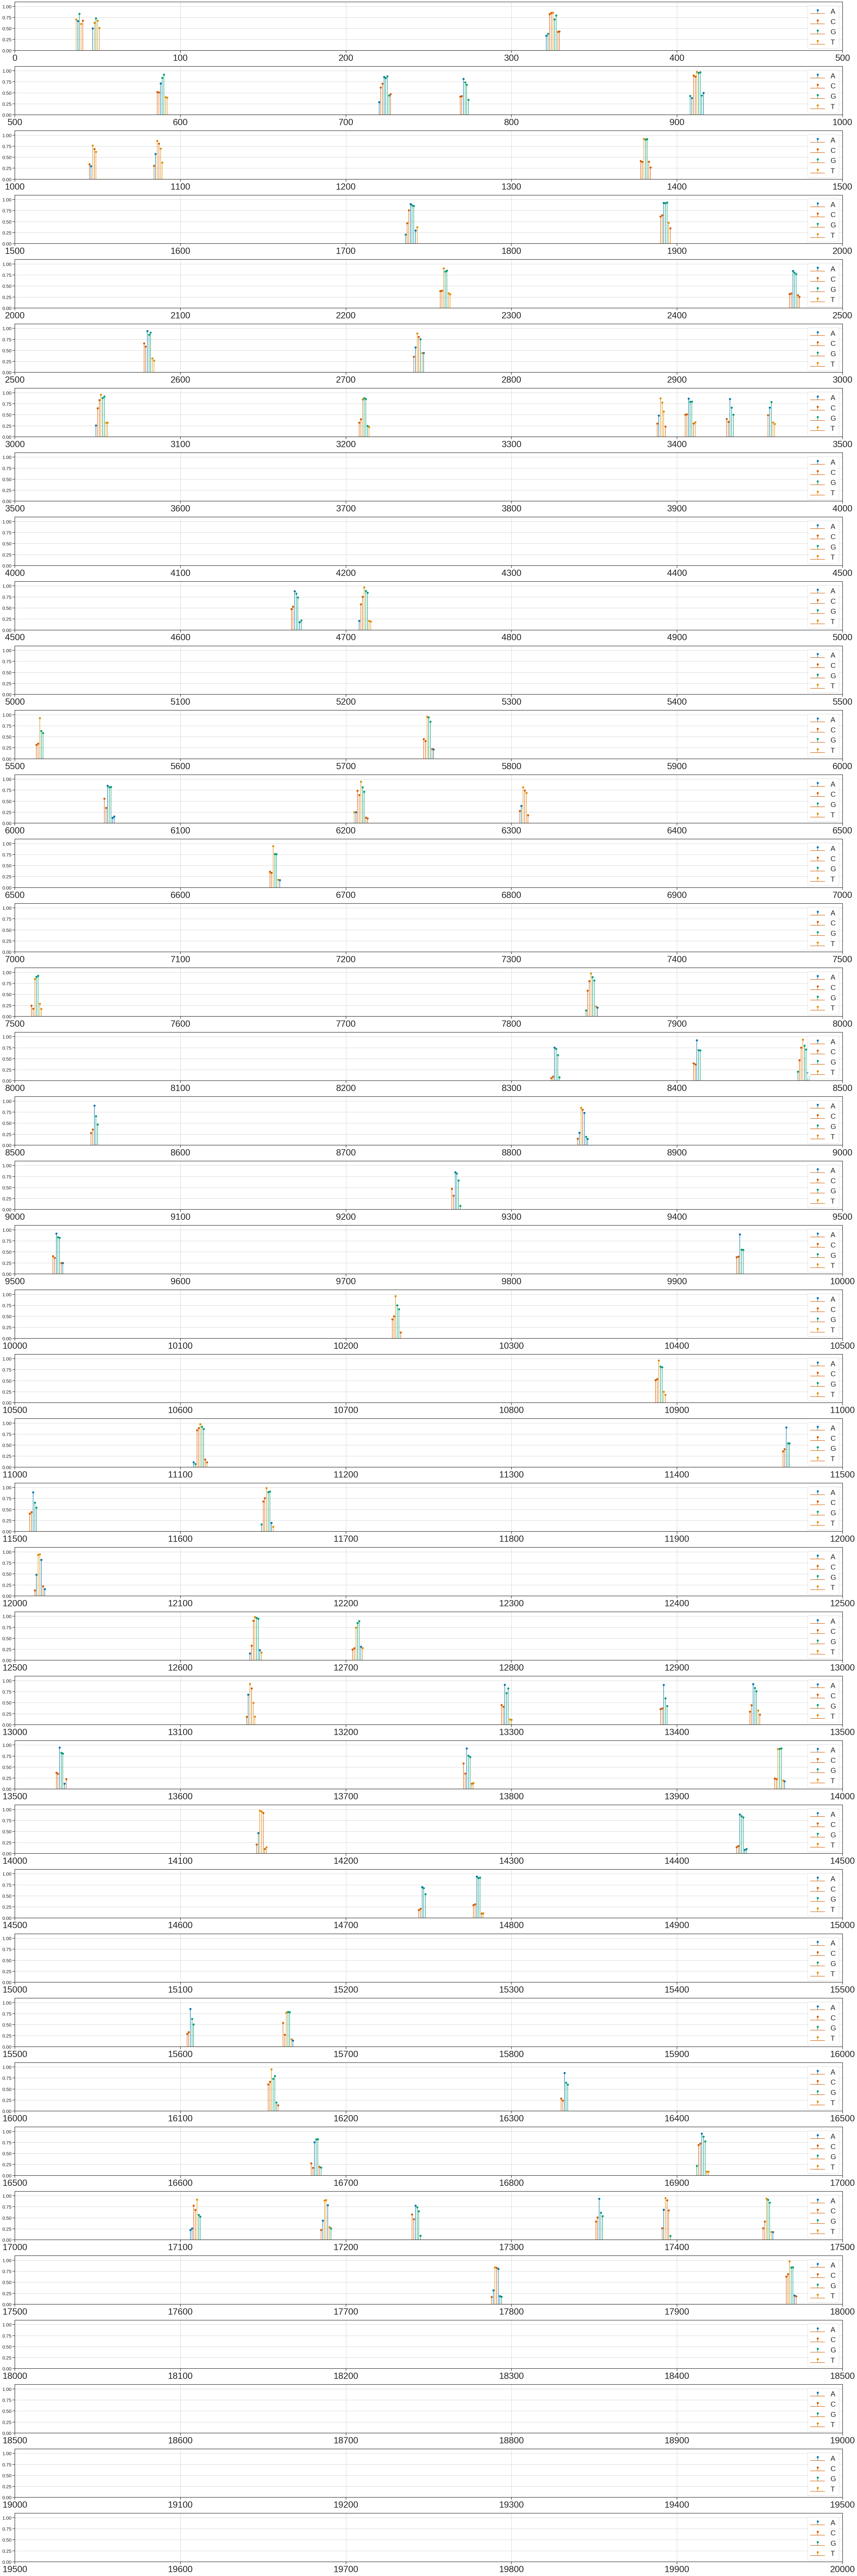

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def expand_list(nums):
    result = []
    for num in nums:
        expanded_range = list(range(num - 2, num + 3))  # Creates a list from num-2 to num+2
        result.extend(expanded_range)
    return sorted(set(result))  # Sorts the list and removes duplicates


for genome in genomes:
    step=500
    nrows=math.ceil(len(dataframe_dict_sampleCompare[genome])/step)
    print(genome, nrows)
    nrows=min(40,nrows)
    n=0

    palette ={"A": "C0", "T": "C1", "G": "C2", "C": "C3"}
    fig, axs = plt.subplots(nrows=nrows, ncols=1,figsize=(40,3*nrows), sharey=True)

    while n < nrows:
        min_x=n*step
        max_x=(n+1)*step
        subset=dataframe_dict_sampleCompare[genome][(dataframe_dict_sampleCompare[genome]["Position"]>(min_x)) & (dataframe_dict_sampleCompare[genome]["Position"]<max_x)]
        
        filtered_df = subset[subset['Mod_fraction'] > 0.7]
        positions_filtered = filtered_df["Position"].to_list()
        expanded_positions_filtered = expand_list(positions_filtered)
        expanded_filtered_df=subset[subset["Position"].isin(expanded_positions_filtered)]
        
    #     ax=sns.barplot(data=subset, x='Position', y='Mod_fraction', ax=axs[n], hue="Mononucleotide", dodge=False, palette=palette)

        subset_A=expanded_filtered_df[expanded_filtered_df["Mononucleotide"]=="A"]
        subset_C=expanded_filtered_df[expanded_filtered_df["Mononucleotide"]=="C"]
        subset_G=expanded_filtered_df[expanded_filtered_df["Mononucleotide"]=="G"]
        subset_T=expanded_filtered_df[expanded_filtered_df["Mononucleotide"]=="T"]
    
    

        axs[n].stem(subset_A["Position"], subset_A["Mod_fraction"], 'C0', markerfmt = 'C0o', label = "A" )
        axs[n].stem(subset_C["Position"], subset_C["Mod_fraction"], 'C3', markerfmt = 'C3o', label = "C" )
        axs[n].stem(subset_G["Position"], subset_G["Mod_fraction"], 'C2', markerfmt = 'C2o', label = "G" )
        axs[n].stem(subset_T["Position"], subset_T["Mod_fraction"], 'C1', markerfmt = 'C1o', label = "T" )

        

        axs[n].set_ylim(0, 1.1)
        axs[n].set_xlim(min_x, max_x)
        axs[n].legend(loc=1, fontsize=24)
        axs[n].tick_params(axis='x', which='major', labelsize=30)
        axs[n].tick_params(axis='y', which='major', labelsize=16)


        print("{:10.2f}".format(100*n/nrows), "%",end = "\r" )
        n=n+1


    fig.savefig(output_modfrac_png)
plt.tight_layout()
plt.show()




W09-2B 8


/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1062571/364110845.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
/home/lmf/anaconda3/envs/Mosaic/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

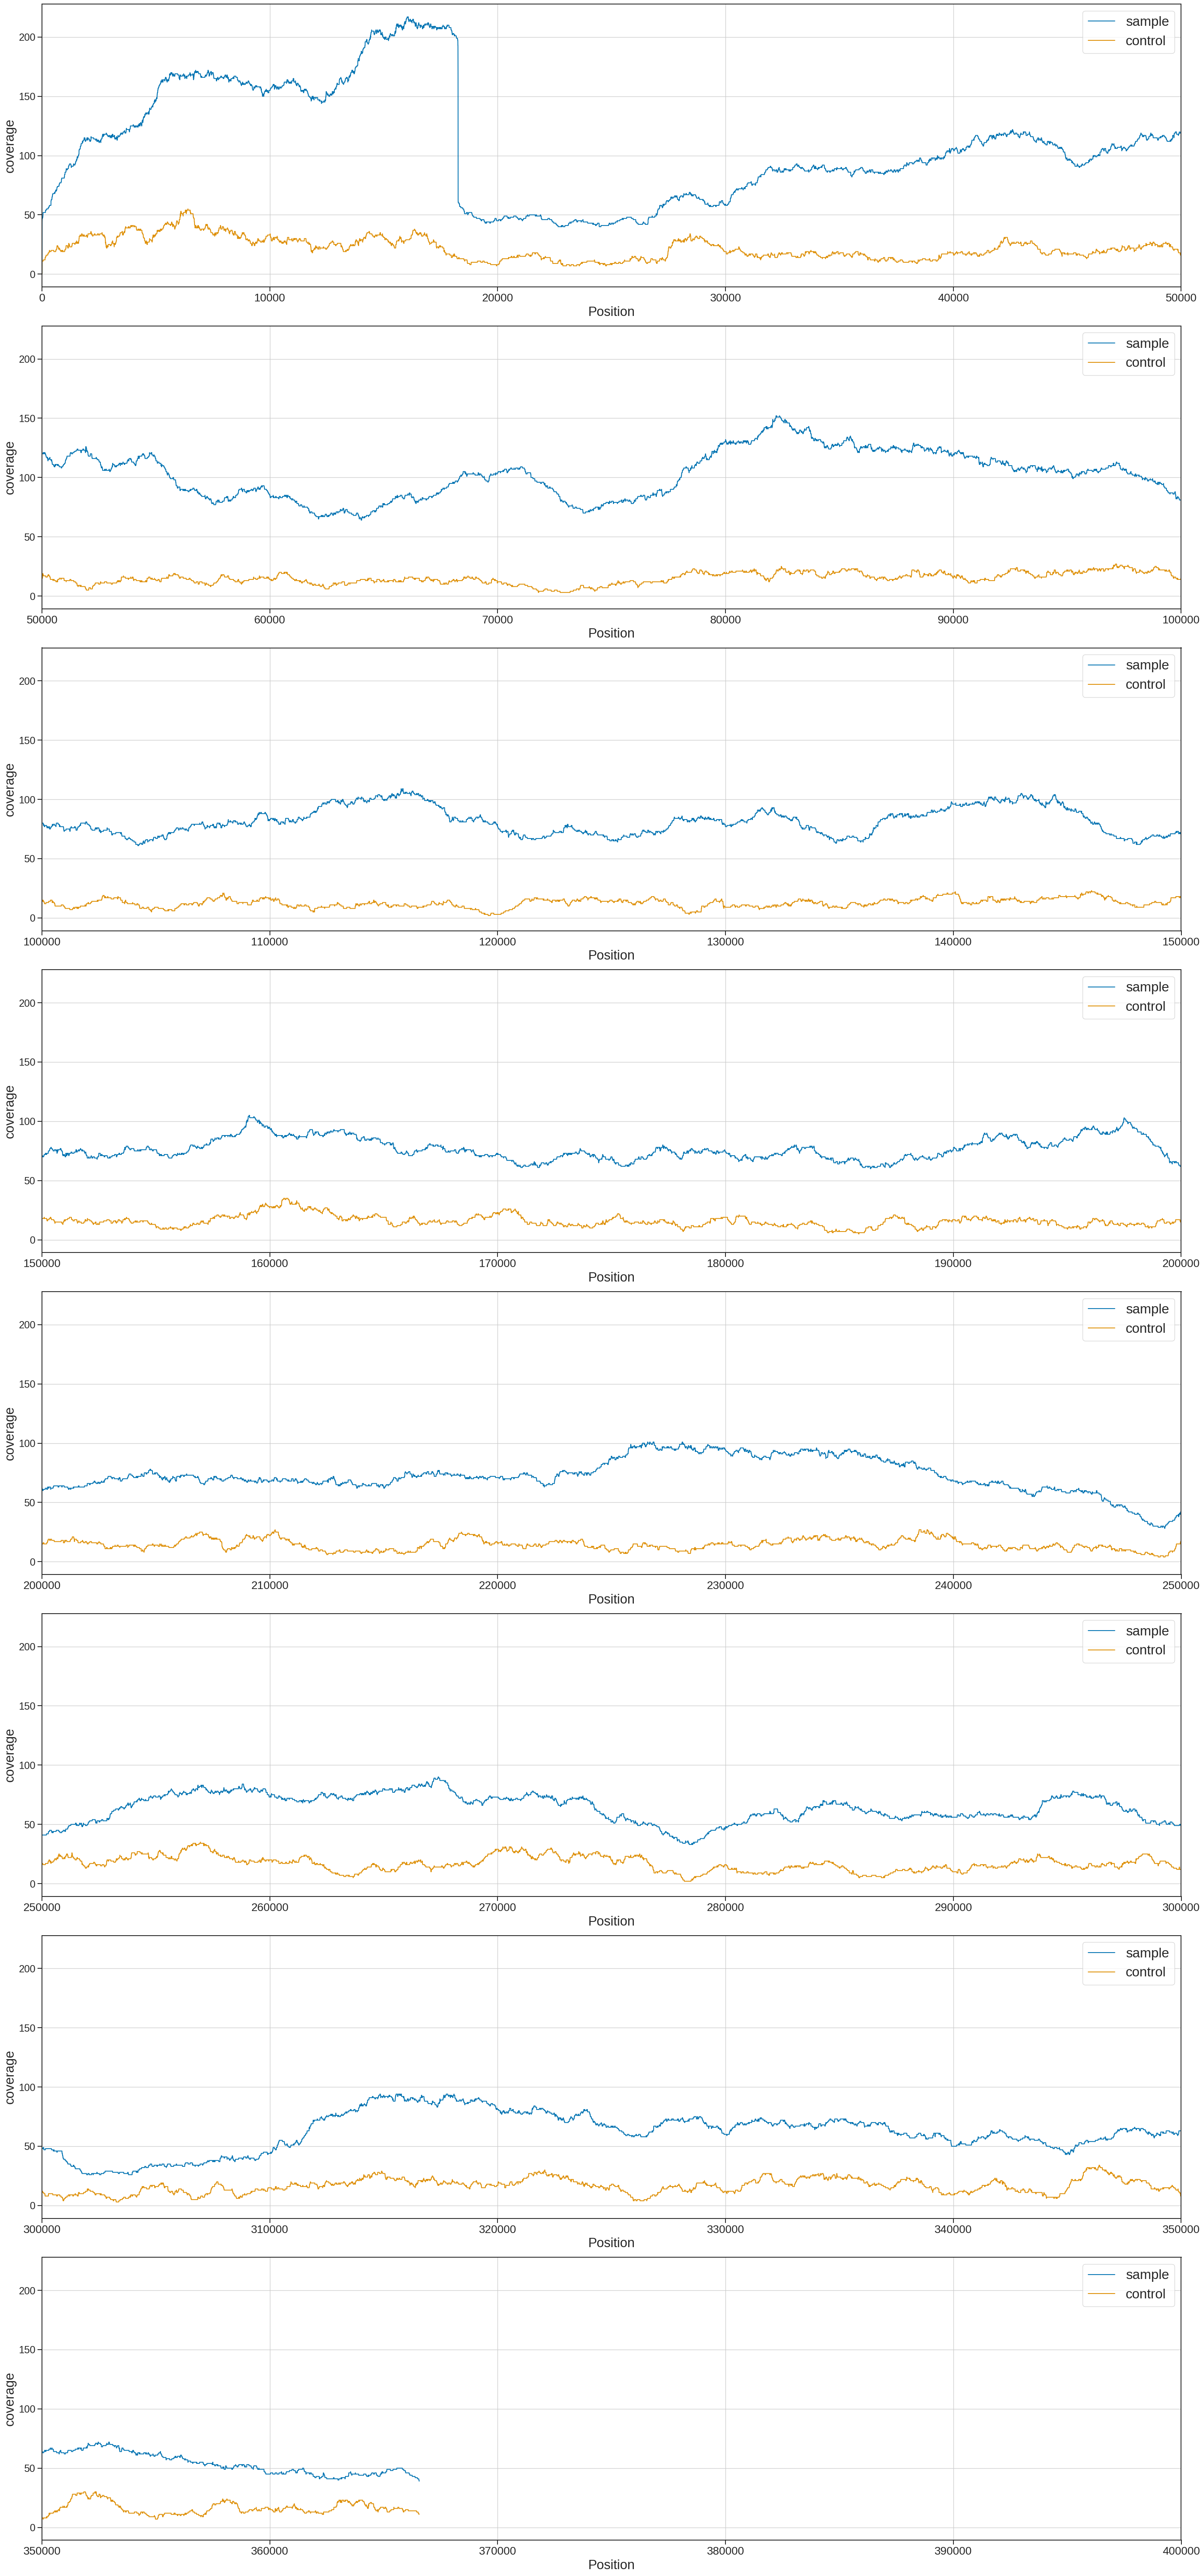

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def expand_list(nums):
    result = []
    for num in nums:
        expanded_range = list(range(num - 2, num + 3))  # Creates a list from num-2 to num+2
        result.extend(expanded_range)
    return sorted(set(result))  # Sorts the list and removes duplicates


for genome in genomes:
    step=50000
    n=0
    nrows=math.ceil(len(dataframe_dict_sampleCompare[genome])/step)
    print(genome, nrows)

    palette ={"A": "C0", "T": "C1", "G": "C2", "C": "C3"}
    fig, axs = plt.subplots(nrows=nrows, ncols=1,figsize=(30,8*nrows), sharey=True)

    while n < nrows:
        min_x=n*step
        max_x=(n+1)*step
        subset=dataframe_dict_sampleCompare[genome][(dataframe_dict_sampleCompare[genome]["Position"]>(min_x)) & (dataframe_dict_sampleCompare[genome]["Position"]<max_x)]
        
        sns.lineplot(data=subset, x='Position', y='coverage_sample', ax=axs[n], palette=palette, label="sample")
        sns.lineplot(data=subset, x='Position', y='coverage_control', ax=axs[n], palette=palette, label="control")

        axs[n].set_ylabel("coverage")
        axs[n].set_xlim(min_x, max_x)

        axs[n].legend(loc=1, fontsize=24)
        axs[n].tick_params(axis='x', which='major', labelsize=20)


        print("{:10.2f}".format(100*n/nrows), "%",end = "\r" )
        n=n+1


#     fig.savefig(output_coverage_png)
plt.tight_layout()
plt.show()


In [105]:
#load nucleotides and create combinations
from matplotlib.gridspec import GridSpec
import math
import seaborn as sns
import matplotlib.pyplot as plt

# df=dataframe_dict_denovo["MN029011_Pseudomonas_phage_iggy"]
df=dataframe_dict_sampleCompare[genomes[0]]



modfrac=df["Mod_fraction"].to_list()
modfrac_p1=modfrac[1:] + modfrac[:1]
modfrac_p2=modfrac[2:] + modfrac[:2]
modfrac_p3=modfrac[3:] + modfrac[:3]
modfrac_p4=modfrac[4:] + modfrac[:4]
modfrac_p5=modfrac[5:] + modfrac[:5]
modfrac_p6=modfrac[6:] + modfrac[:6]
modfrac_p7=modfrac[7:] + modfrac[:7]
modfrac_p8=modfrac[8:] + modfrac[:8]
modfrac_p9=modfrac[9:] + modfrac[:9]
modfrac_p10=modfrac[10:] + modfrac[:10]

modfrac_m1=modfrac[-1:] + modfrac[:-1]
modfrac_m2=modfrac[-2:] + modfrac[:-2]

df["modfrac_p1"]=modfrac_p1
df["modfrac_p2"]=modfrac_p2
df["modfrac_p3"]=modfrac_p3
df["modfrac_p4"]=modfrac_p4
df["modfrac_p5"]=modfrac_p5
df["modfrac_p6"]=modfrac_p6
df["modfrac_p7"]=modfrac_p7
df["modfrac_p8"]=modfrac_p8
df["modfrac_p9"]=modfrac_p9
df["modfrac_p10"]=modfrac_p10

df["modfrac_m1"]=modfrac_m1
df["modfrac_m2"]=modfrac_m2

mono=df["Mononucleotide"].to_list()

nuc_p1=mono[1:] + mono[:1]
nuc_p2=mono[2:] + mono[:2]
nuc_p3=mono[3:] + mono[:3]
nuc_p4=mono[4:] + mono[:4]
nuc_p5=mono[5:] + mono[:5]
nuc_p6=mono[6:] + mono[:6]
nuc_p7=mono[7:] + mono[:7]
nuc_p7=mono[7:] + mono[:7]
nuc_p8=mono[8:] + mono[:8]
nuc_p9=mono[9:] + mono[:9]
nuc_p10=mono[10:] + mono[:10]

nuc_m1=mono[-1:] + mono[:-1]
nuc_m2=mono[-2:] + mono[:-2]

df["nuc_p1"]=nuc_p1
df["nuc_p2"]=nuc_p2
df["nuc_p3"]=nuc_p3
df["nuc_p4"]=nuc_p4
df["nuc_p5"]=nuc_p5
df["nuc_p6"]=nuc_p6
df["nuc_p7"]=nuc_p7
df["nuc_p7"]=nuc_p7
df["nuc_p8"]=nuc_p8
df["nuc_p9"]=nuc_p9
df["nuc_p10"]=nuc_p10

df["nuc_m1"]=nuc_m1
df["nuc_m2"]=nuc_m2


In [116]:
import timeit
categories=["Mononucleotide","Dinucleotide","Trinucleotide","Tetranucleotide",
             "Pentanucleotide","Hexanucleotide","Heptanucleotide",]
           # "Octanucleotide", "Nonanucleotide", "Decanucleotide"]
modfracs=["modfrac_m2","modfrac_m1","Mod_fraction","modfrac_p1", "modfrac_p2",
          "modfrac_p3","modfrac_p4","modfrac_p5","modfrac_p6",
          "modfrac_p7","modfrac_p8", "modfrac_p9","modfrac_p10"]
times=[]
n=0
cmap="rainbow"
for category in categories:
    start = timeit.default_timer()
    sel_cols=modfracs[0:5+n]
    sel_cols.append(category)
    df_nucleotide=df[sel_cols].groupby(category).mean()
    df_nucleotide["max"]= df_nucleotide.T.max()
    df_nucleotide[~df_nucleotide.index.str.contains("X")].sort_values(by="max", ascending=False).style.background_gradient(cmap=cmap,vmin=0.15, vmax=1).to_html(genome + "_" + category + "_table_sampleCompare.html")

    print( category + ":  ", timeit.default_timer() - start) 
    times.append(timeit.default_timer() - start)
    n=n+1


Mononucleotide:   0.04706794582307339
Dinucleotide:   0.11975762341171503
Trinucleotide:   0.13603625167161226
Tetranucleotide:   0.20212573185563087
Pentanucleotide:   0.47771834302693605
Hexanucleotide:   1.6448973678052425
Heptanucleotide:   8.217863455414772


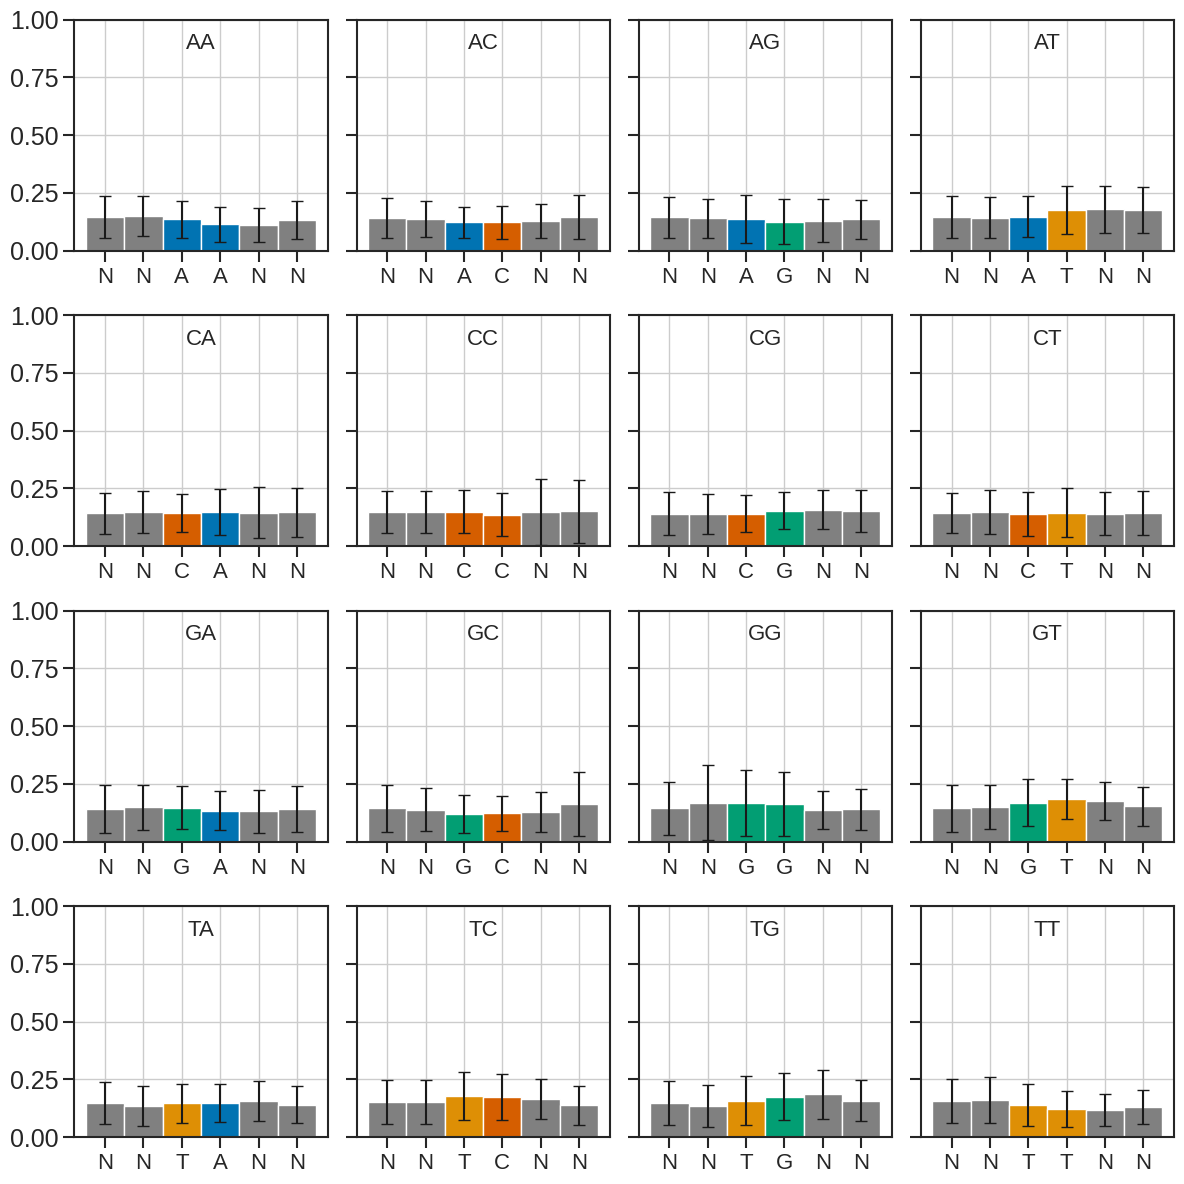

In [118]:
import itertools as it
combinations_temp=list(it.product(["A", "C", "G", "T"], repeat=2))
combinations=[]
for comb in combinations_temp:
    combinations.append(''.join(comb))
combinations


df = df[~df["Dinucleotide"].str.contains("X", na=False)]

ncols=4
nrows=int(np.ceil(len(combinations)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(12,3*nrows), sharey=True)
n=0
i=0
j=0
for kmer in combinations:
    name=kmer
    group=df[df["Dinucleotide"] == kmer]
    if len(group)>0:
        x=-2
        j=int(np.floor((n)/ncols))
        i=n-(j*ncols)

        #print(i,j)
        for column in ["modfrac_m2", "modfrac_m1", "Mod_fraction", "modfrac_p1",  "modfrac_p2", "modfrac_p3"]:
            if x==0 or x==1:
                color=palette[name[x]]
            else:
                color="gray"
            data=group[column].to_list()
            mean=np.nanmean(data)
            std_error = np.nanstd(data, ddof=1)
            ax=axs[j,i]
            ax.bar(x=x, #x-coordinates of bars
               height=mean, #height of bars
               yerr=std_error, #error bar width
               width=1,
               capsize=4, color=color) #length of error bar caps
            x=x+1
            ax.set_ylim(0, 1)
            ax.set_xticks(range(-2, 4, 1))
            ax.set_xticklabels(["N","N",name[0],name[1],"N","N"], )
            ax.tick_params(axis='x', which='major', labelsize=16)
        ax.set_title(name,x=0.5, y=0.75, fontsize=16)

    n=n+1
    print("{:10.2f}".format(100*n/len(combinations)), "%",end = "\r" )

plt.tight_layout()
plt.savefig(output_dinucleotide_histogram_pdf, format="pdf", bbox_inches="tight")
plt.show()

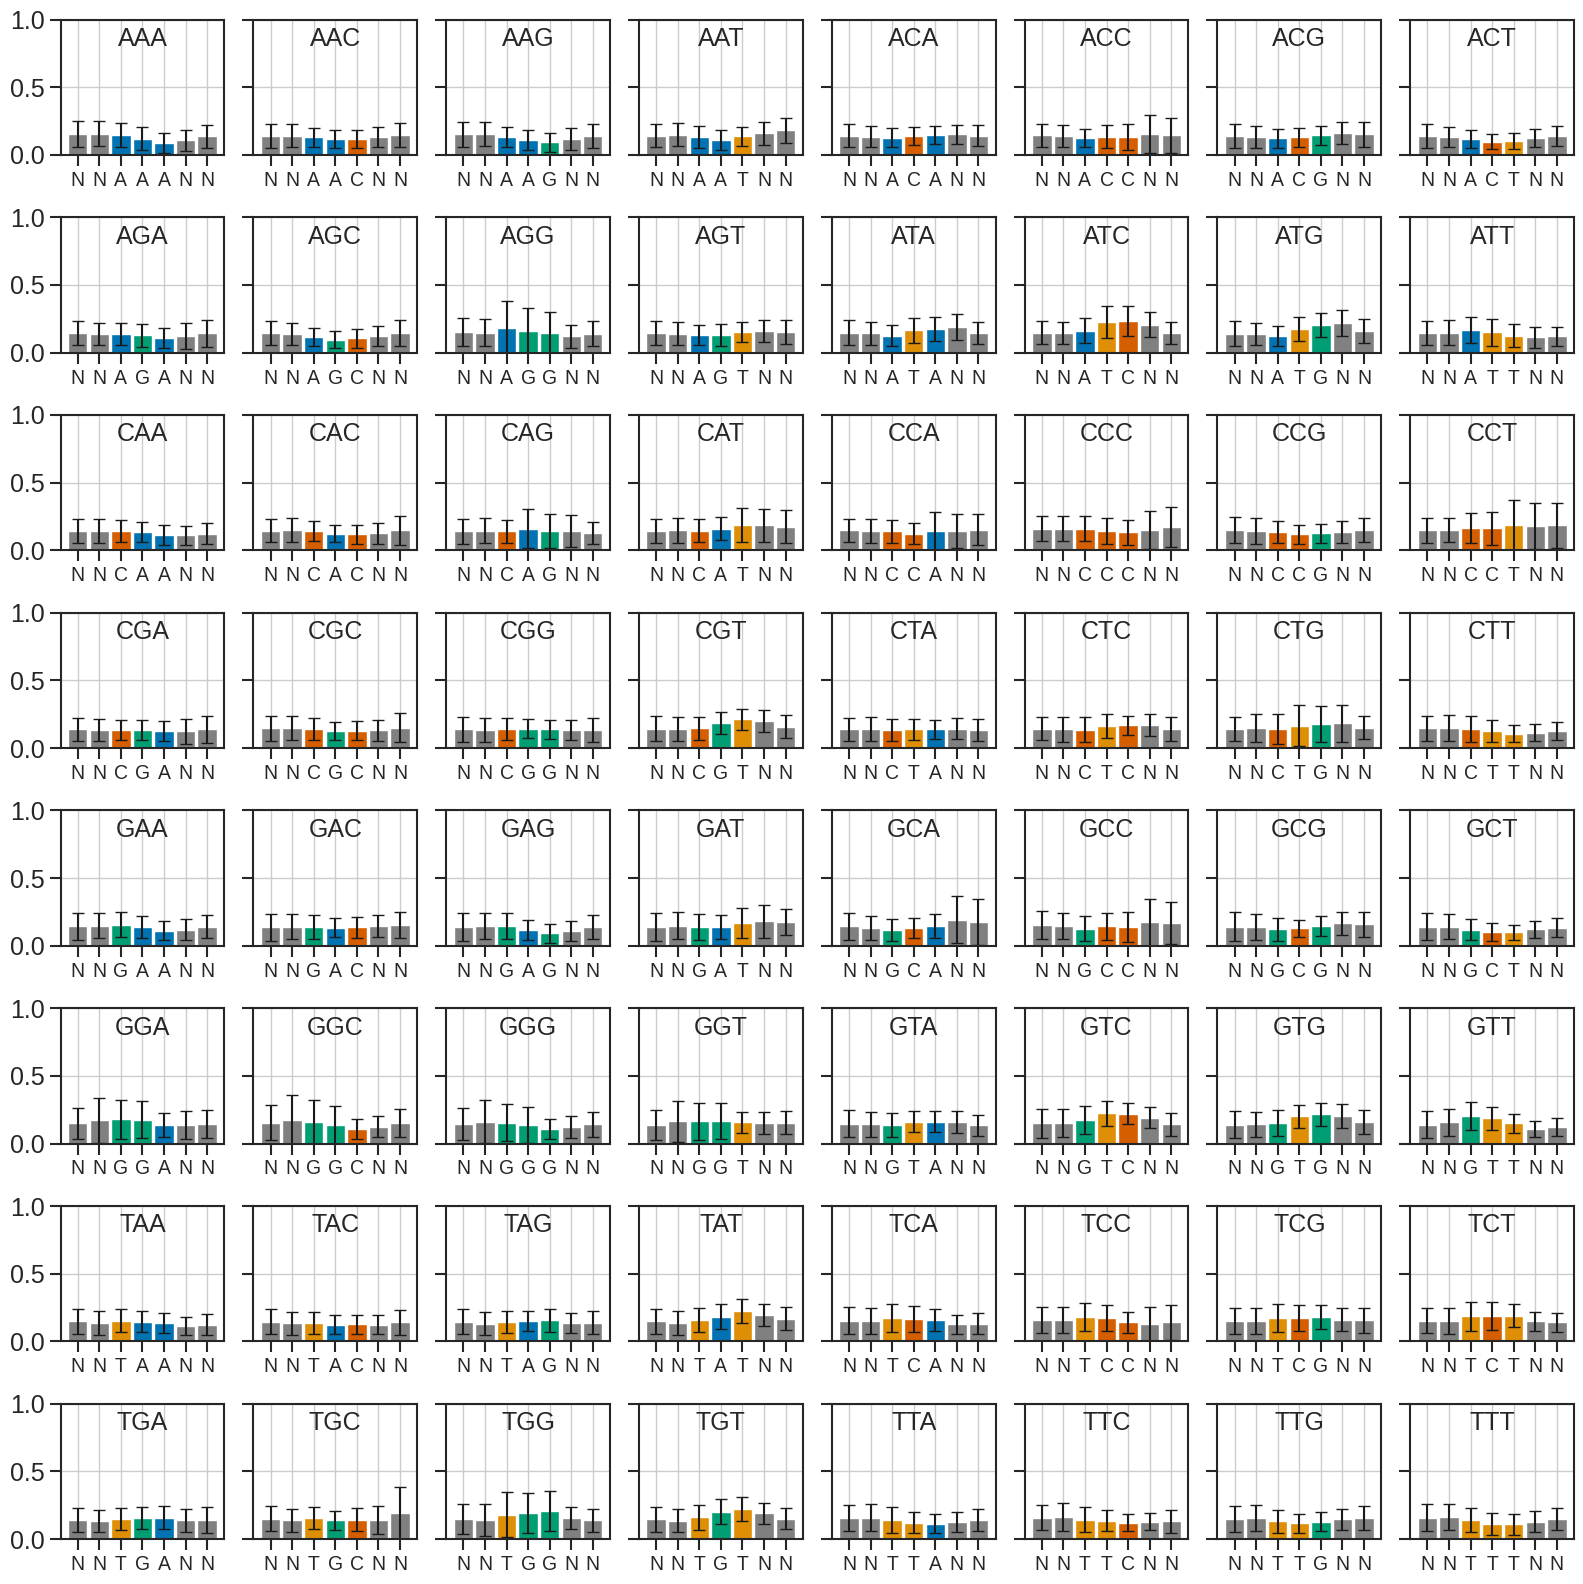

In [121]:
import itertools as it
combinations_temp=list(it.product(["A", "C", "G", "T"], repeat=3))
combinations=[]
for comb in combinations_temp:
    combinations.append(''.join(comb))
combinations

df = df[~df["Trinucleotide"].str.contains("X", na=False)]


ncols=8
nrows=int(np.ceil(len(combinations)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(16,2*nrows), sharey=True)
n=0
i=0
j=0
for kmer in combinations:
    name=kmer
    group=df[df["Trinucleotide"] == kmer]
    
    x=-2
    j=int(np.floor((n)/ncols))
    i=n-(j*ncols)
    
    if len(group)>0:

        for column in ["modfrac_m2", "modfrac_m1", "Mod_fraction", "modfrac_p1",  "modfrac_p2", "modfrac_p3", "modfrac_p4"]:
            if x==0 or x==1 or x==2:
                color=palette[name[x]]
            else:
                color="gray"
            data=group[column].to_list()
            mean=np.nanmean(data)
            std_error = np.nanstd(data, ddof=1)
            ax=axs[j,i]
            ax.bar(x=x, #x-coordinates of bars
               height=mean, #height of bars
               yerr=std_error, #error bar width
               width=.9,
               capsize=4, color=color) #length of error bar caps
            x=x+1
            ax.set_ylim(0, 1)
            ax.set_xticks(range(-2, 5, 1))
            ax.set_xticklabels(["N","N",name[0],name[1],name[2],"N","N"], )
            ax.tick_params(axis='x', which='major', labelsize=14)
            ax.set_title(name,x=0.5, y=0.60, fontsize=18)
    
    n=n+1
    print("{:10.2f}".format(100*n/len(combinations)), "%",end = "\r" )
plt.tight_layout()
plt.savefig(output_trinucleotide_histogram_pdf, format="pdf", bbox_inches="tight")
plt.show()

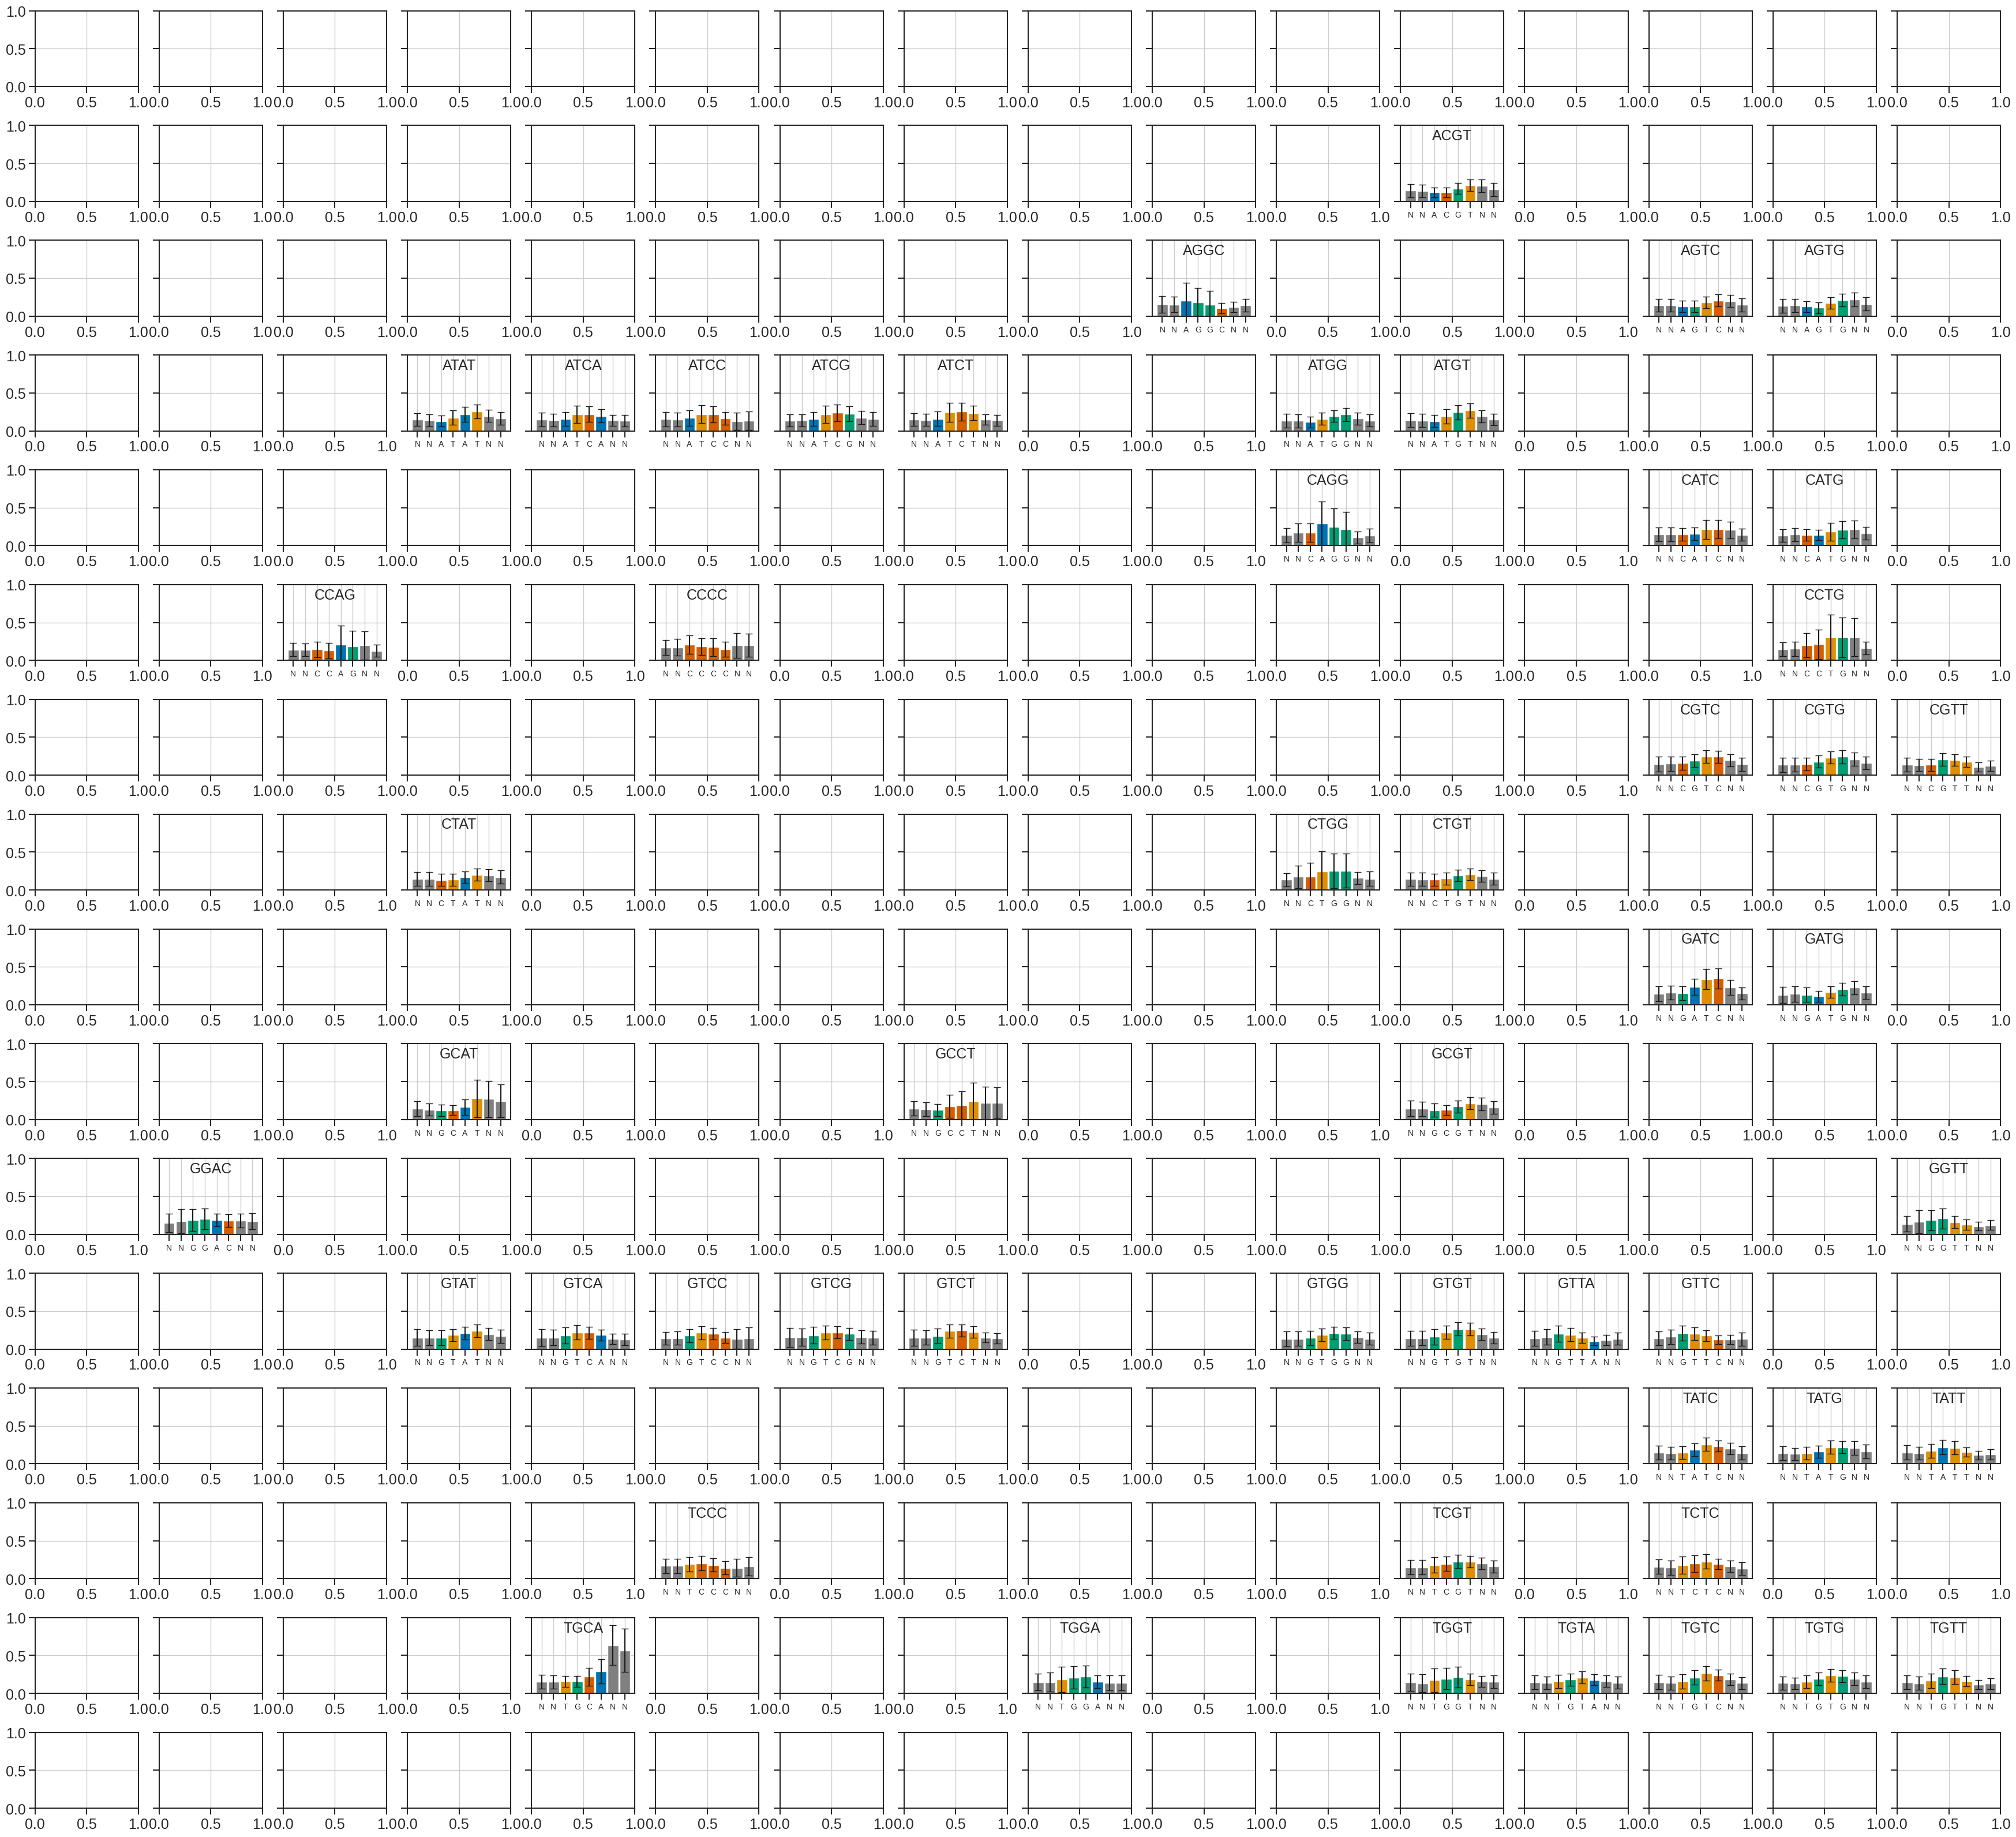

In [123]:
combinations_temp=list(it.product(["A", "C", "G", "T"], repeat=4))
combinations=[]
for comb in combinations_temp:
    combinations.append(''.join(comb))
combinations


df = df[~df["Tetranucleotide"].str.contains("X", na=False)]


ncols=16
nrows=int(np.ceil(len(combinations)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(35,2*nrows), sharey=True)
n=0
i=0
j=0
min_modfrac=0.7
for kmer in combinations:
    name=kmer
    group=df[df["Tetranucleotide"] == kmer]
    x=-2
    j=int(np.floor((n)/ncols))
    i=n-(j*ncols)
    
    if len(group)>0:

        if ((group["Mod_fraction"].mean() > min_modfrac) or (group["modfrac_p1"].mean() > min_modfrac) or (group["modfrac_p2"].mean() > min_modfrac) or (group["modfrac_p3"].mean() > min_modfrac)):
            #print(i,j)
            for column in ["modfrac_m2", "modfrac_m1", "Mod_fraction", "modfrac_p1",  "modfrac_p2", "modfrac_p3", "modfrac_p4","modfrac_p5"]:
                if x==0 or x==1 or x==2 or x==3:
                    color=palette[name[x]]
                else:
                    color="gray"
                data=group[column].to_list()
                mean=np.nanmean(data)
                std_error = np.nanstd(data, ddof=1)
                ax=axs[j,i]
                ax.bar(x=x, #x-coordinates of bars
                   height=mean, #height of bars
                   yerr=std_error, #error bar width
                   width=.9,
                   capsize=4, color=color) #length of error bar caps
                x=x+1
                ax.set_ylim(0, 1)
                ax.set_xticks(range(-2, 6, 1))
                ax.set_xticklabels(["N","N",name[0],name[1],name[2],name[3],"N","N"], )
                ax.tick_params(axis='x', which='major', labelsize=10)
                ax.set_title(name,x=0.5, y=0.60, fontsize=18)


    n=n+1
    print("{:10.2f}".format(100*n/len(combinations)), "%",end = "\r" )

plt.tight_layout()
plt.savefig(output_tetranucleotide_histogram_pdf, format="pdf", bbox_inches="tight")
plt.show()

In [126]:
combinations_temp=list(it.product(["A", "C", "G", "T"], repeat=5))
combinations=[]
for comb in combinations_temp:
    combinations.append(''.join(comb))
combinations



df = df[~df["Pentanucleotide"].str.contains("X", na=False)]

ncols=32
nrows=int(np.ceil(len(combinations)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(90,2*nrows), sharey=True)
n=0
i=0
j=0
min_modfrac=0.7
for kmer in combinations:
    name=kmer
    group=df[df["Pentanucleotide"] == kmer]
    x=-2
    j=int(np.floor((n)/ncols))
    i=n-(j*ncols)
    
    if len(group)>0:

        if ((group["Mod_fraction"].mean() > min_modfrac) or (group["modfrac_p1"].mean() > min_modfrac) or (group["modfrac_p2"].mean() > min_modfrac) or (group["modfrac_p3"].mean() > min_modfrac)):
            for column in ["modfrac_m2", "modfrac_m1", "Mod_fraction", "modfrac_p1",  "modfrac_p2", "modfrac_p3", "modfrac_p4","modfrac_p5","modfrac_p6"]:
                if x==0 or x==1 or x==2 or x==3 or x==4:
                    color=palette[name[x]]
                else:
                    color="gray"
                data=group[column].to_list()
                mean=np.nanmean(data)
                std_error = np.nanstd(data, ddof=1)
                ax=axs[j,i]
                ax.bar(x=x, #x-coordinates of bars
                   height=mean, #height of bars
                   yerr=std_error, #error bar width
                   width=.9,
                   capsize=4, color=color) #length of error bar caps
                x=x+1
                ax.set_ylim(0, 1)
                ax.set_xticks(range(-2, 7, 1))
                ax.set_xticklabels(["N","N",name[0],name[1],name[2],name[3],name[4],"N","N"], )
                ax.tick_params(axis='x', which='major', labelsize=10)
                ax.set_title(name,x=0.5, y=0.60, fontsize=14)


    n=n+1
    print("{:10.2f}".format(100*n/len(combinations)), "%",end = "\r" )

plt.tight_layout()
plt.savefig(output_pentanucleotide_histogram_pdf, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
combinations_temp=list(it.product(["A", "C", "G", "T"], repeat=6))
combinations=[]
for comb in combinations_temp:
    combinations.append(''.join(comb))
combinations



df = df[~df["Hexanucleotide"].str.contains("X", na=False)]


ncols=64
nrows=int(np.ceil(len(combinations)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols ,figsize=(300,2*nrows), sharey=True)
n=0
i=0
j=0
min_modfrac=0.7
for kmer in combinations:
    name=kmer
    group=df[df["Hexanucleotide"] == kmer]
    x=-2
    j=int(np.floor((n)/ncols))
    i=n-(j*ncols)
    
    if len(group)>0:

        if ((group["Mod_fraction"].mean() > min_modfrac) or (group["modfrac_p1"].mean() > min_modfrac) or (group["modfrac_p2"].mean() > min_modfrac) or (group["modfrac_p3"].mean() > min_modfrac)):
            for column in ["modfrac_m2", "modfrac_m1", "Mod_fraction", "modfrac_p1",  "modfrac_p2", "modfrac_p3", "modfrac_p4","modfrac_p5","modfrac_p6","modfrac_p7"]:
                if x==0 or x==1 or x==2 or x==3:
                    color=palette[name[x]]
                else:
                    color="gray"
                data=group[column].to_list()
                mean=np.nanmean(data)
                std_error = np.nanstd(data, ddof=1)
                ax=axs[j,i]
                ax.bar(x=x, #x-coordinates of bars
                   height=mean, #height of bars
                   yerr=std_error, #error bar width
                   width=.9,
                   capsize=4, color=color) #length of error bar caps
                x=x+1
                ax.set_ylim(0, 1)
                ax.set_xticks(range(-2, 8, 1))
                ax.set_xticklabels(["N","N",name[0],name[1],name[2],name[3],name[4],name[5],"N","N"], )
                ax.tick_params(axis='x', which='major', labelsize=10)            
                ax.set_title(name,x=0.5, y=0.60, fontsize=10)
    n=n+1
    print("{:10.2f}".format(100*n/len(combinations)), "%",end = "\r" )

       
#         fig.savefig(genome + "_" + column + "_sampleCompare.png")
plt.tight_layout()
plt.savefig(output_hexanucleotide_histogram_pdf, format="pdf", bbox_inches="tight")
plt.show()